In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Sonnets Dataset and poetry generator

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
import numpy as np 

In [ ]:
tokenizer = Tokenizer()
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt \
    -O /tmp/sonnets.txt
data = open('/tmp/sonnets.txt').read()

corpus = data.lower().split("\n")


tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)

max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

--2020-09-16 20:30:17--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 2607:f8b0:400e:c09::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93578 (91K) [text/plain]
Saving to: ‘/tmp/sonnets.txt’

/tmp/sonnets.txt    100%[===================>]  91.38K  --.-KB/s    in 0.001s  

2020-09-16 20:30:17 (105 MB/s) - ‘/tmp/sonnets.txt’ saved [93578/93578]



In [ ]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(200, return_sequences = True)))
model.add(Dropout(0.2))
model.add(LSTM(150))
model.add(Dense(2048, activation = 'relu', kernel_regularizer = regularizers.l2(0.01)))
model.add(Dense(total_words, activation = 'softmax'))

adam = Adam(lr = 0.01)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print(model.summary())


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 10, 100)           321100    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 10, 400)           481600    
_________________________________________________________________
dropout_5 (Dropout)          (None, 10, 400)           0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 150)               330600    
_________________________________________________________________
dense_4 (Dense)              (None, 2048)              309248    
_________________________________________________________________
dense_5 (Dense)              (None, 3211)              6579339   
Total params: 8,021,887
Trainable params: 8,021,887
Non-trainable params: 0
____________________________________________

In [ ]:
 history = model.fit(predictors, label, epochs=100, verbose=2)

Epoch 1/100
484/484 - 5s - loss: 6.9177 - accuracy: 0.0194
Epoch 2/100
484/484 - 5s - loss: 6.5036 - accuracy: 0.0202
Epoch 3/100
484/484 - 5s - loss: 6.3980 - accuracy: 0.0257
Epoch 4/100
484/484 - 5s - loss: 6.2805 - accuracy: 0.0308
Epoch 5/100
484/484 - 5s - loss: 6.1800 - accuracy: 0.0369
Epoch 6/100
484/484 - 5s - loss: 6.0960 - accuracy: 0.0394
Epoch 7/100
484/484 - 5s - loss: 6.0180 - accuracy: 0.0440
Epoch 8/100
484/484 - 5s - loss: 5.9239 - accuracy: 0.0480
Epoch 9/100
484/484 - 5s - loss: 5.8156 - accuracy: 0.0545
Epoch 10/100
484/484 - 5s - loss: 5.7062 - accuracy: 0.0609
Epoch 11/100
484/484 - 5s - loss: 5.6018 - accuracy: 0.0653
Epoch 12/100
484/484 - 5s - loss: 5.4948 - accuracy: 0.0706
Epoch 13/100
484/484 - 5s - loss: 5.3892 - accuracy: 0.0768
Epoch 14/100
484/484 - 5s - loss: 5.2758 - accuracy: 0.0853
Epoch 15/100
484/484 - 5s - loss: 5.1659 - accuracy: 0.0918
Epoch 16/100
484/484 - 5s - loss: 5.0519 - accuracy: 0.1001
Epoch 17/100
484/484 - 5s - loss: 4.9450 - accura

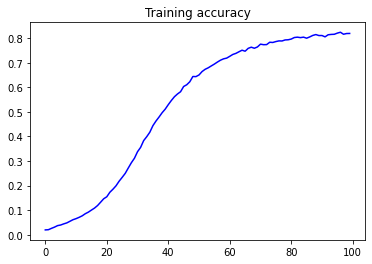

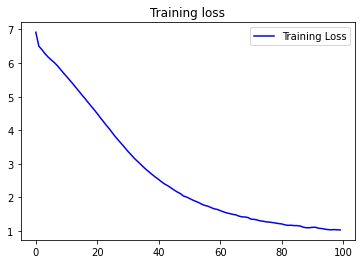

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [ ]:
seed_text = "Somewhere i have never travelled,gladly beyond"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Somewhere i have never travelled,gladly beyond lie with me ' should tell that who how seen thee bring more much ever better bright love ' there alone so need you bright love days bright bold find dost show thee words right hue out past or past age under needing faith till you brought of chest lie did young with thee here quite quite gone kill me made such strife strife kind ' lies made new grow on 'tis thought truth ' back back again away possesseth hence hence bring hence defeated tongue each muse belong love releasing say if they never stand by true ' '
